#Multilabel multiclass classification

(src: https://github.com/DhavalTaunk08/NLP_scripts/blob/master/Transformers_multilabel_distilbert.ipynb)

Using the Jigsaw toxic data from Kaggle (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

The data contains the text, and the labels using one hot encoding

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment.



In [1]:
! pip install transformers

In [68]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
import logging
logging.basicConfig(level=logging.ERROR)

In [69]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [70]:
print(device)

cuda


In [71]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [72]:
data = pd.read_csv('final_dataset.tsv', sep='\t')

In [73]:
data.columns

Index(['PMID', 'Title/Abstract', 'MeshTerms', 'SemanticTypes'], dtype='object')

In [74]:
data.head()

,PMID,Title/Abstract,MeshTerms,SemanticTypes
0,34694464,limit use dithionit quench determin topolog me...,D005456;D008565,T130;T192;T116;T123
1,34694463,isol post traumat astereognosi case base revie...,D006225;D013236,T039;T023
2,34694462,loss chromatin remodel ddm caus segreg distort...,D017360;D029681,T116;T002
3,34694461,identif novel genom wide pleiotrop associ oral...,D058685,T028;T045
4,34694460,rare frequent lethal complic pulmonari vein is...,D001281;D017115;D004937;D011667,T023;T047;T046;T190;T061


In [75]:
data.drop(['PMID'], inplace=True, axis=1)
data.drop(['MeshTerms'], inplace=True, axis=1)
data.head()

,Title/Abstract,SemanticTypes
0,limit use dithionit quench determin topolog me...,T130;T192;T116;T123
1,isol post traumat astereognosi case base revie...,T039;T023
2,loss chromatin remodel ddm caus segreg distort...,T116;T002
3,identif novel genom wide pleiotrop associ oral...,T028;T045
4,rare frequent lethal complic pulmonari vein is...,T023;T047;T046;T190;T061


In [76]:
df_onehot = pd.concat([data.drop('SemanticTypes', 1), data['SemanticTypes'].str.get_dummies(sep=";")], 1)
df_onehot.head()

,Title/Abstract,T001,T002,T004,T005,T007,T008,T010,T011,T012,...,T190,T191,T192,T194,T195,T196,T197,T200,T201,T204
0,limit use dithionit quench determin topolog me...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,isol post traumat astereognosi case base revie...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,loss chromatin remodel ddm caus segreg distort...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,identif novel genom wide pleiotrop associ oral...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,rare frequent lethal complic pulmonari vein is...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [77]:
new_df = pd.DataFrame()
new_df['text'] = df_onehot['Title/Abstract']
new_df['labels'] = df_onehot.iloc[:, 1:].values.tolist()

In [78]:
new_df.head()

,text,labels
0,limit use dithionit quench determin topolog me...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,isol post traumat astereognosi case base revie...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,loss chromatin remodel ddm caus segreg distort...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,identif novel genom wide pleiotrop associ oral...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,rare frequent lethal complic pulmonari vein is...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [79]:
sample_df = new_df
sample_df

,text,labels
0,limit use dithionit quench determin topolog me...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,isol post traumat astereognosi case base revie...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,loss chromatin remodel ddm caus segreg distort...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,identif novel genom wide pleiotrop associ oral...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,rare frequent lethal complic pulmonari vein is...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
2875799,radioact level relat geolog substrat dynam nat...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2875800,effect novel endoscop report system voic recog...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2875801,neurotrop sar cov neurolog diseas central nerv...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2875802,offlin tdcs modul prefront cortic subcort cere...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [80]:
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

In [81]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [82]:
# Defining some key variables that will be used later on in the training
MAX_LEN = tokenizer.model_max_length
MAX_LEN = 512
EPOCHS = 20
LEARNING_RATE = 2e-05


In [83]:
train_size = 0.8
train_data=sample_df.sample(frac=train_size,random_state=200)
test_data=sample_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN)

FULL Dataset: (2875804, 2)
TRAIN Dataset: (2300643, 2)
TEST Dataset: (575161, 2)


In [84]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained("dmis-lab/biobert-v1.1")
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 124)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [85]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [86]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [87]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            torch.save(model.state_dict(), 'biobert.mod')
        loss.backward()
        optimizer.step()

In [88]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [91]:
# ONLY NEEDED ON FIRST RUN
torch.save(model.state_dict(), 'biobert.mod')

In [92]:
def validate(target, outputs):
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
    val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))
    
    print(f"Hamming Score = {val_hamming_score}")
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"Hamming Loss = {val_hamming_loss}")
    print()

In [93]:
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 8,
                
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 8,
                
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [94]:

model.load_state_dict(torch.load('biobert.mod'))
for epoch in range(EPOCHS):
   
    train(epoch)
    ###
    outputs, targets = validation(testing_loader)
    final_outputs = np.array(outputs) >=0.5
    validate(targets, final_outputs)
    ###
    
    

0it [00:00, ?it/s]

Epoch: 0, Loss:  0.6876566410064697


14it [00:23,  1.66s/it]


KeyboardInterrupt: 

In [71]:
outputs, targets = validation(testing_loader)



8987it [34:07,  4.39it/s]


In [72]:
final_outputs = np.array(outputs) >=0.5

In [73]:
for ii in range(150):
    ind_tar = [i for i, x in enumerate(targets[ii]) if x]
    print(ind_tar)
    ind_pred = [i for i, x in enumerate(final_outputs[ii]) if x]
    print(ind_pred)
    print()

[52]
[39]

[53]
[87]

[18, 29]
[29, 53]

[37]
[37]

[62, 73]
[62, 73, 123]

[62, 99]
[62, 99]

[15]
[52, 53]

[65, 94, 99]
[94]

[26, 33, 111]
[40, 112]

[27, 40, 53]
[53, 87]

[54, 69, 71, 72, 110]
[80]

[49, 52, 54, 72, 82, 87, 110]
[50, 71, 72, 90]

[18]
[53]

[52]
[39, 52]

[27, 48, 53, 70, 110]
[27, 53]

[21, 28, 55, 95, 100]
[]

[53]
[48, 53]

[56, 61, 69, 72, 87]
[56, 72]

[66]
[66]

[34]
[59]

[57, 110]
[57, 110]

[38]
[]

[27]
[]

[65, 66, 79, 110]
[65, 78, 79, 110]

[39, 69]
[39, 69]

[15]
[15, 39]

[39]
[17, 39]

[48]
[48]

[79]
[65]

[94, 98]
[34]

[3, 59]
[38, 39, 59]

[38, 39, 65, 71, 82]
[65]

[49]
[49]

[16, 25, 38, 51, 55, 72, 76]
[25, 38]

[96, 98, 100, 102]
[96, 100]

[24, 39, 112]
[51]

[27, 65, 110]
[65]

[39]
[]

[42]
[53]

[40]
[40]

[115]
[53]

[46, 48, 49, 53, 80, 109]
[48, 53]

[40]
[]

[66]
[65, 66, 94, 99]

[62]
[32, 38]

[53]
[38, 53]

[66]
[66]

[27, 29, 39, 52]
[39, 52]

[33]
[33, 53]

[27, 40, 53]
[40, 53]

[38, 39]
[39, 104]

[41]
[94, 119]

[0, 4, 39]


In [6]:
validate(targets, final_outputs)

NameError: name 'validate' is not defined

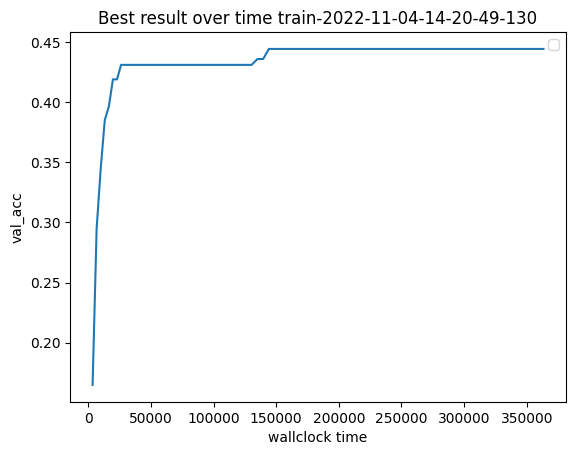

,epoch,val_acc,st_worker_timestamp,st_worker_time,st_worker_iter,st_decision,st_status,trial_id,config_epochs,config_lr,config_dropout_rate,config_model_name,config_sample_frac,config_max_len,config_pre_classifier_size,config_batch_size,config_num_workers,config_save,st_tuner_time
0,1,0.164876,1.667575e+09,3382.498871,0,CONTINUE,InProgress,0,8,0.000022,0.5,dmis-lab/biobert-v1.1,0.1,306,768,34,4,False,3389.055926
1,2,0.295168,1.667578e+09,6625.828862,1,CONTINUE,InProgress,0,8,0.000022,0.5,dmis-lab/biobert-v1.1,0.1,306,768,34,4,False,6627.890575
2,3,0.344881,1.667582e+09,9873.650710,2,CONTINUE,InProgress,0,8,0.000022,0.5,dmis-lab/biobert-v1.1,0.1,306,768,34,4,False,9876.653161
3,4,0.385218,1.667585e+09,13120.483055,3,CONTINUE,InProgress,0,8,0.000022,0.5,dmis-lab/biobert-v1.1,0.1,306,768,34,4,False,13125.489507
4,5,0.396393,1.667588e+09,16367.431765,4,CONTINUE,InProgress,0,8,0.000022,0.5,dmis-lab/biobert-v1.1,0.1,306,768,34,4,False,16374.410637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1,0.281995,1.667912e+09,5926.650404,0,CONTINUE,InProgress,40,8,0.000021,0.0,allenai/scibert_scivocab_uncased,0.1,500,768,20,4,False,340150.656654
131,2,0.336704,1.667918e+09,11740.626535,1,CONTINUE,InProgress,40,8,0.000021,0.0,allenai/scibert_scivocab_uncased,0.1,500,768,20,4,False,345963.478957
132,3,0.402754,1.667923e+09,17560.141505,2,CONTINUE,InProgress,40,8,0.000021,0.0,allenai/scibert_scivocab_uncased,0.1,500,768,20,4,False,351781.105595
133,4,0.431721,1.667929e+09,23374.175284,3,CONTINUE,InProgress,40,8,0.000021,0.0,allenai/scibert_scivocab_uncased,0.1,500,768,20,4,False,357593.852487


In [89]:
from syne_tune.experiments import load_experiment
tuning_experiment = load_experiment("train-2022-11-04-14-20-49-130")
tuning_experiment.plot()
tuning_experiment.results

In [91]:
tuning_experiment.best_config()

{'epoch': 7,
 'val_acc': 0.4443833088555841,
 'trial_id': 17,
 'config_epochs': 8,
 'config_lr': 2.010530530098351e-05,
 'config_dropout_rate': 0.0,
 'config_model_name': 'allenai/scibert_scivocab_uncased',
 'config_sample_frac': 0.1,
 'config_max_len': 403,
 'config_pre_classifier_size': 768,
 'config_batch_size': 23,
 'config_num_workers': 5,
 'config_save': False}

In [92]:
tuning_experiment

ExperimentResult(name='train-2022-11-04-14-20-49-130', results=     epoch   val_acc  st_worker_timestamp  st_worker_time  st_worker_iter  \
0        1  0.164876         1.667575e+09     3382.498871               0   
1        2  0.295168         1.667578e+09     6625.828862               1   
2        3  0.344881         1.667582e+09     9873.650710               2   
3        4  0.385218         1.667585e+09    13120.483055               3   
4        5  0.396393         1.667588e+09    16367.431765               4   
..     ...       ...                  ...             ...             ...   
130      1  0.281995         1.667912e+09     5926.650404               0   
131      2  0.336704         1.667918e+09    11740.626535               1   
132      3  0.402754         1.667923e+09    17560.141505               2   
133      4  0.431721         1.667929e+09    23374.175284               3   
134      5  0.429255         1.667935e+09    29193.280644               4   

    st_decis